# TP1: Data Exploration

## Winter 2023 - BIN710 Data Mining (UdeS)

First assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP1_data.csv    ---> Data

├── tp1.ipynb   ---> Jupyter Notebook

└── TP1.pdf    ---> Tasks to complete

### Metadata
csv file with :
- 59 objects
- 4 features
- 3 classes (as factors)

### Goal
Are all 4 features relevant for a classification task. The classifier will be distance based (KNN with K=5 or nearest centroid classifier)

---

### 1. Data Representation

In [506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import shapiro 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestCentroid
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import patches
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture

Read, inspect and check for inconsistencies

In [507]:
datafile = Path("TP1_data.csv")
df = pd.read_csv(datafile, index_col=0)
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [508]:
# Check types, NaN or negative data
print(f"Data types : {np.unique(df.dtypes.to_list())}") # types

print(f"Number of rows with any NaN : {len(df.isna().any()[df.isna().any()])}") #NaN

# Check for neg data
print(f"Number of cols with negative values : {len((df < 0).any()[(df < 0).any()].index)}") # Negative vals

Data types : [dtype('int64') dtype('float64')]
Number of rows with any NaN : 0
Number of cols with negative values : 0


In [509]:
# Extracting features
cols = df.columns.to_list()
features = cols[:-1]
print(features)

['attribut1', 'attribut2', 'attribut3', 'attribut4']


In [510]:
# Separating features and classes
X = df[features]
y = df["classe"]

In [511]:
X.head()

,attribut1,attribut2,attribut3,attribut4
id1,38.0,33.0,10.0,19.0
id2,38.2,23.4,17.0,16.6
id3,33.0,24.0,19.0,23.0
id4,31.0,21.0,29.0,16.0
id5,37.0,27.0,24.0,12.0


In [512]:
y.head()

id1    0
id2    0
id3    0
id4    0
id5    0
Name: classe, dtype: int64

#### a) Evaluate correlations and possible transformations

Check correlations between features and then comparing between classes

In [513]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()


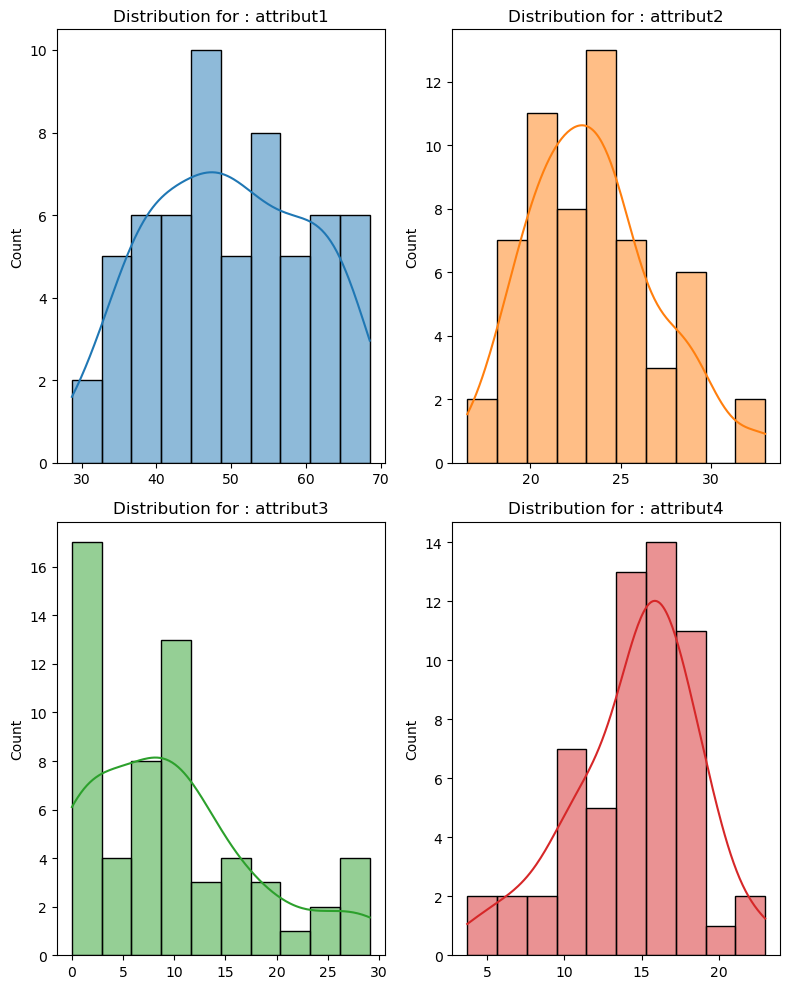

In [514]:
# Check distributions
get_distributions(X, features, 2, 2, bins=10, kde=True)


attribut1,2 and 4 seem normally distributed while 3 is more spread out (in kurtosis terms)

In [515]:
def check_normality(df, features):
    for feat in features:
        norm = shapiro(df[feat])
        if norm.pvalue < 0.05:
            print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
        else:
            print(f"{feat} follows a normal distribution (null hypothesis)")

In [516]:
# Check for normality 
check_normality(X, features)

attribut1 follows a normal distribution (null hypothesis)
attribut2 follows a normal distribution (null hypothesis)
attribut3 is not normally distributed since pval=0.00028542501968331635 < 0.05
attribut4 follows a normal distribution (null hypothesis)


**Check dispersions measures**

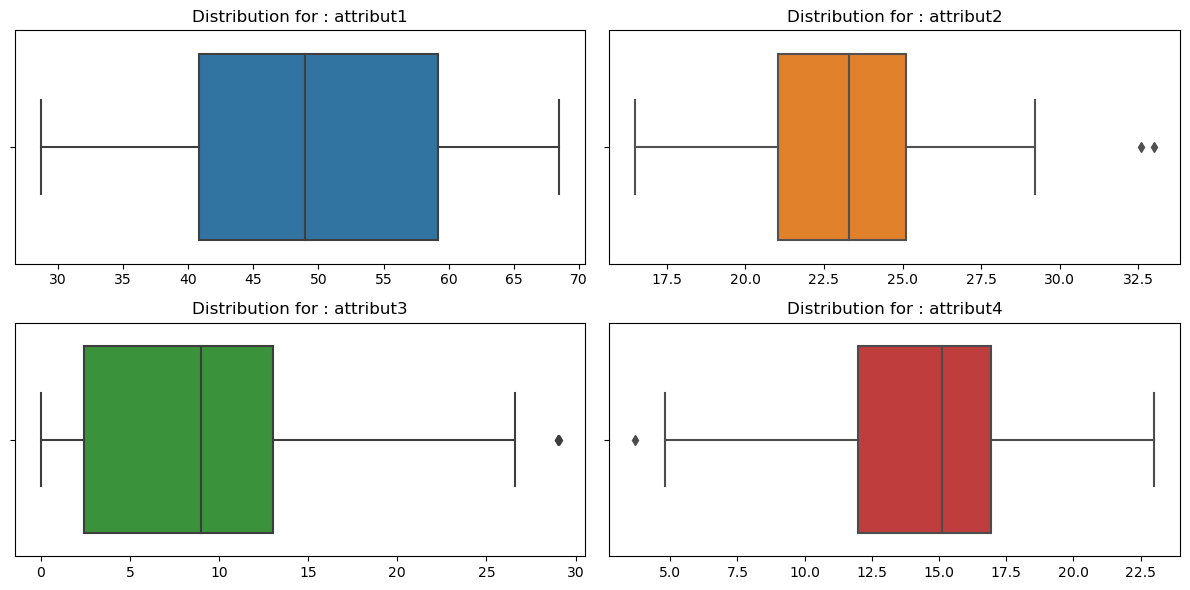

In [517]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.boxplot(data=df, x=feat, ax=axes[i], color=sns.color_palette()[i])
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

<AxesSubplot: >

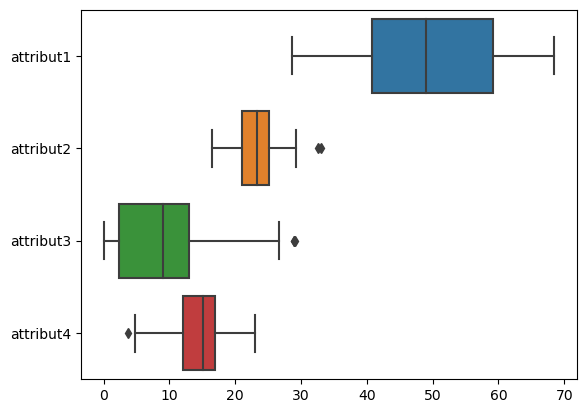

In [518]:
sns.boxplot(data=df[features], orient="h")

In [519]:
def get_dispersions(df, features):
    for feat in features:
        mean = np.mean(df[feat])
        median = np.median(df[feat])
        sd = np.std(df[feat])
        print(f"For feature {feat} : Mean={mean:.2f}, Median={median:.2f}, Std_dev={sd:.2f}")

In [520]:
get_dispersions(X, features)

For feature attribut1 : Mean=49.79, Median=49.00, Std_dev=10.40
For feature attribut2 : Mean=23.49, Median=23.30, Std_dev=3.50
For feature attribut3 : Mean=9.59, Median=9.00, Std_dev=8.11
For feature attribut4 : Mean=14.56, Median=15.10, Std_dev=4.02


We see a few outliers and some distributions are narrower than others

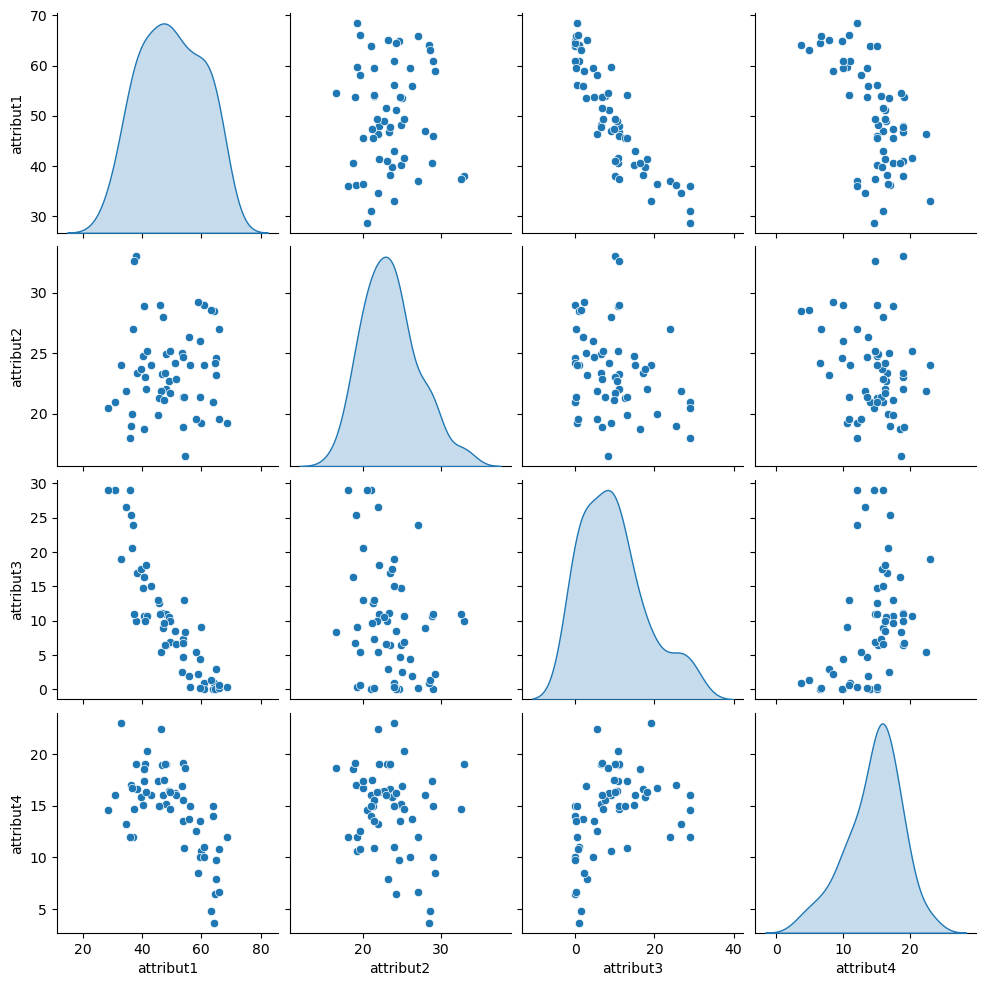

In [521]:
# Pairplot for features
g = sns.pairplot(X, diag_kind="kde")

g.tight_layout();

From the pairplot feature comparisons, we can say : 
- attribut1 and attribut3 seem inversely correlated
- attribut 1 and attribut 4 seem weakly inversely correlated 

In [522]:
# Pearson correlation
X.corr(method="pearson")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.017056,-0.890974,-0.622651
attribut2,0.017056,1.000000,-0.258163,-0.242347
attribut3,-0.890974,-0.258163,1.000000,0.372298
attribut4,-0.622651,-0.242347,0.372298,1.000000


In [523]:
# Check with other correlation coefficients for non-normal attribut3
X.corr(method="spearman")

,attribut1,attribut2,attribut3,attribut4
attribut1,1.000000,0.057114,-0.907870,-0.582645
attribut2,0.057114,1.000000,-0.229549,-0.212478
attribut3,-0.907870,-0.229549,1.000000,0.450973
attribut4,-0.582645,-0.212478,0.450973,1.000000


Distributions for each feature per class

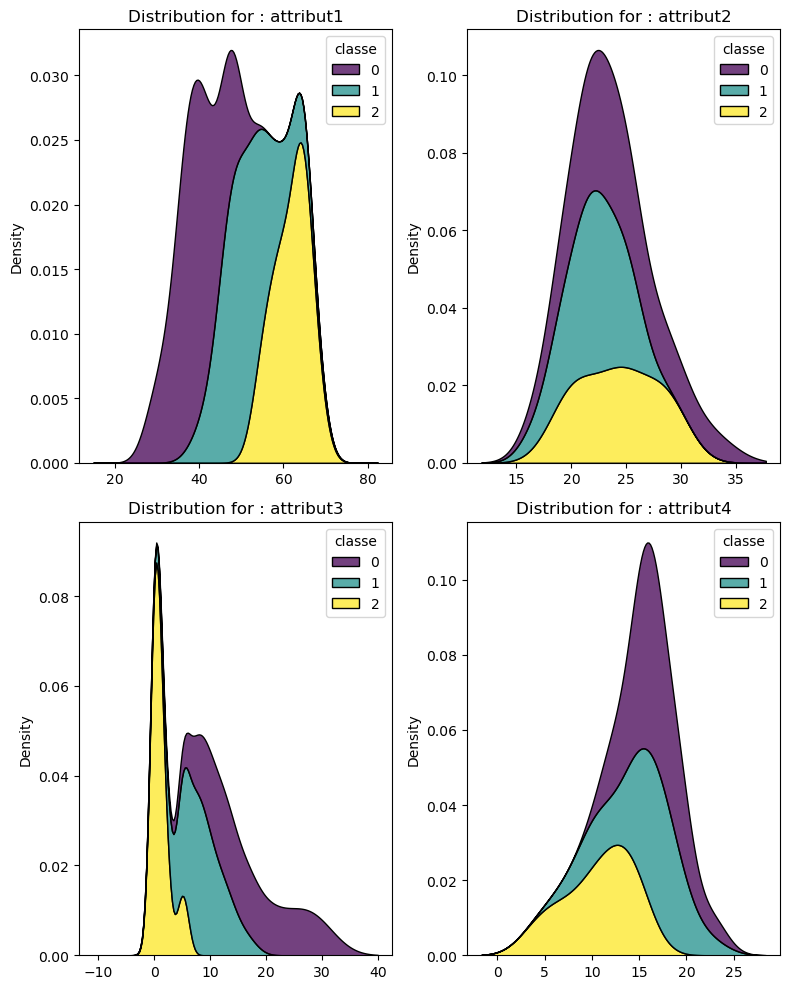

In [524]:
plt_rows = 2
plt_cols = 2

fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
axes = axes.ravel()

for i, feat in enumerate(features):
    plot = sns.kdeplot(data=df, x=feat, ax=axes[i], hue="classe", multiple="stack", palette="viridis")
    plot.set(title=f"Distribution for : {feat}")
    plot.set(xlabel="")

fig.tight_layout()

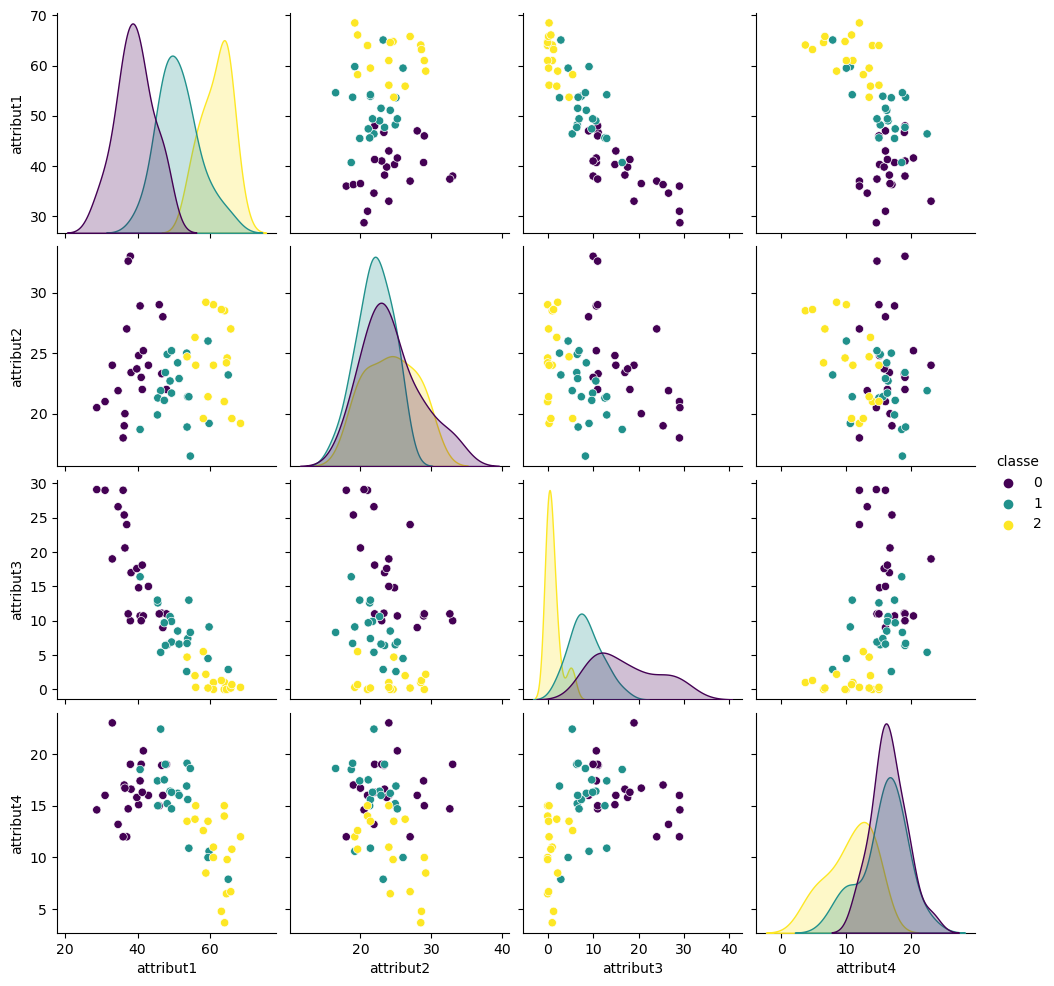

In [525]:
# Pairplot for features
g = sns.pairplot(df, diag_kind="kde", hue="classe", palette="viridis")

g.tight_layout();

#### b) Principal Component Analysis (PCA)

PCA will probably reduce the correlation between combinations of attribut1-3 and attribut1-4 thus the classification model would probably benefit from PCA. 

However, since we do not have a lot of features (4D can still be visualized without dimensionality reduction) I don't think it is necessary since passing from 4 to either 1, 2 or 3 dimensions and the gain in model performance might not be better.

We will perform PCA, choose a right number of components to keep and visualize the data post transformation

In [526]:
def plot_explained_variance(data, n_components):
    # Calculate cumulated variance
    model = PCA(n_components=n_components)
    cumul = []
    tot = 0
    pca = model.fit(data)
    for i in pca.explained_variance_ratio_:
        cumul.append(i+tot)
        tot += i
    # Plot
    n_compo = np.arange(1, pca.n_components_+1)
    plt.figure()
    plt.plot(n_compo, cumul, marker="o")
    plt.axhline(y=n_components, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", "% variance explained"])
    return pca

Number of components to keep for PCA according to Kaiser's_rule : 3


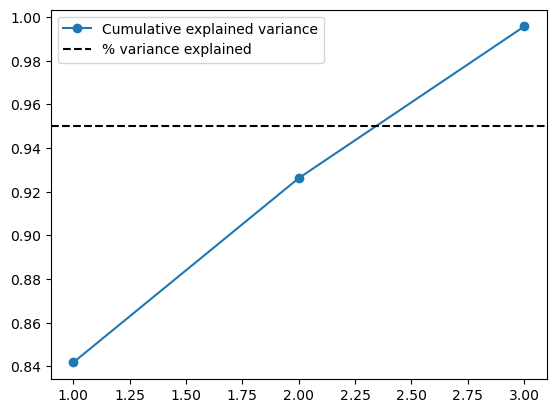

In [527]:
# 95% variance explained
# pca95 = PCA(0.95).fit(X)
pca95 = plot_explained_variance(X, 0.95)
kaiser_rule = len([i for i in (pca95.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

Number of components to keep for PCA according to Kaiser's_rule : 3


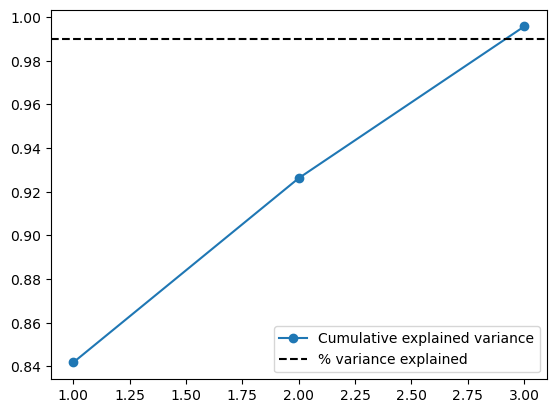

In [528]:
# 99% variance explained
pca99 = plot_explained_variance(X, 0.99)
kaiser_rule = len([i for i in (pca99.explained_variance_ > 1) if i==True])
print(f"Number of components to keep for PCA according to Kaiser's_rule : {kaiser_rule}")

- To capture 95% to 99 of the variance explained we would need 3 components
- Since the explained variance after dimension reduction to 1, 2, 3 dimension dimension are > 1 : 3 components
---

### 2. Distance Measure

Since there are some correlations between some of the features, I hypothesize that the Mahalanobis distance will be better to determine the distance between each objects in regards to its true class

#### a) Caclulate nearest centroids (using Eucledian distance) for each objects with n_components = 2 and 3 and compare with truth

In [529]:
# Fit the model for 2PCs and 3PCs
pca_2c = PCA(n_components=2).fit(X)
pca_3c = PCA(n_components=3).fit(X)

In [530]:
# Dimensionality reduction 2PCs and 3PCs
data2d = pca_2c.transform(X)
data3d = pca_3c.transform(X)
# with y as our classes

**Considering  that PCA scores are centered at zero, it means their euclidean distance to the centroid is basically the array itself.**

In [531]:

print(f"pca_2c centroid : {np.mean(data2d, dtype='float64')}")
print(f"pca_2c centroid : {np.mean(data3d, dtype='float64')}")

pca_2c centroid : -2.3333500856528716e-16
pca_2c centroid : 3.2114925910061025e-16


We can calculate the Manhattan and Euclidean distance to the centroids by :
1. grouping by class
2. calculating the mean
3. Euc = square root of the substraction the value of transformed (or not) datapoint to the mean to the power of 2 (Question 1b)
4. Man = retrieving the absolute value from the substraction of the point to the mean (Question 2a)

For PCA with 2-dimensions

In [532]:
# Get Centroids
pca2c_df = pd.DataFrame(data2d, columns=["pc1","pc2"])
pca2c_df["real_class"] = y.values
pca2c_centroids = pca2c_df.groupby("real_class").mean()
pca2c_centroids

,pc1,pc2
real_class,,
0,13.189847,0.624828
1,-1.671420,-0.087523
2,-15.102837,-0.705632


In [533]:
# Euclidian/Manhattan distances to centroid class for 2PCs

# Difference to centroid
pca2c_dist = pca2c_df.groupby("real_class").transform(lambda x: (x - x.mean())).rename(columns = {"pc1" : "pc1-cent", "pc2" : "pc2-cent"})
# Manhattan dist
pca2c_dist["man"] = np.abs(pca2c_dist["pc1-cent"]) + np.abs(pca2c_dist["pc2-cent"])
# Euclidean dist
pca2c_dist["euc"] = np.sqrt(np.power(pca2c_dist["pc1-cent"], 2) + np.power(pca2c_dist["pc2-cent"], 2))
# Adding PC1, PC2 and classes back
pca2c_dist[["pc1", "pc2"]] = pca2c_df[["pc1", "pc2"]]
pca2c_dist["real_class"] = y.values
pca2c_dist.head()


,pc1-cent,pc2-cent,man,euc,pc1,pc2,real_class
0,-3.191294,10.630896,13.822190,11.099564,9.998553,11.255724,0
1,0.667624,0.074133,0.741757,0.671727,13.857471,0.698961,0
2,7.071894,4.070348,11.142243,8.159621,20.261741,4.695177,0
3,13.373477,-6.068369,19.441846,14.685877,26.563323,-5.443541,0
4,4.779972,-3.891427,8.671399,6.163711,17.969818,-3.266599,0


In [534]:
# Taken from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [535]:
# Extracting PCs per class for confidence ellipses
pca2c_dist[pca2c_dist["real_class"] == 0]["pc1"].head()

0     9.998553
1    13.857471
2    20.261741
3    26.563323
4    17.969818
Name: pc1, dtype: float64

Text(0.5, 0.98, '2PCs : Euc, Man Distances and PC1/PC2 relative to class')

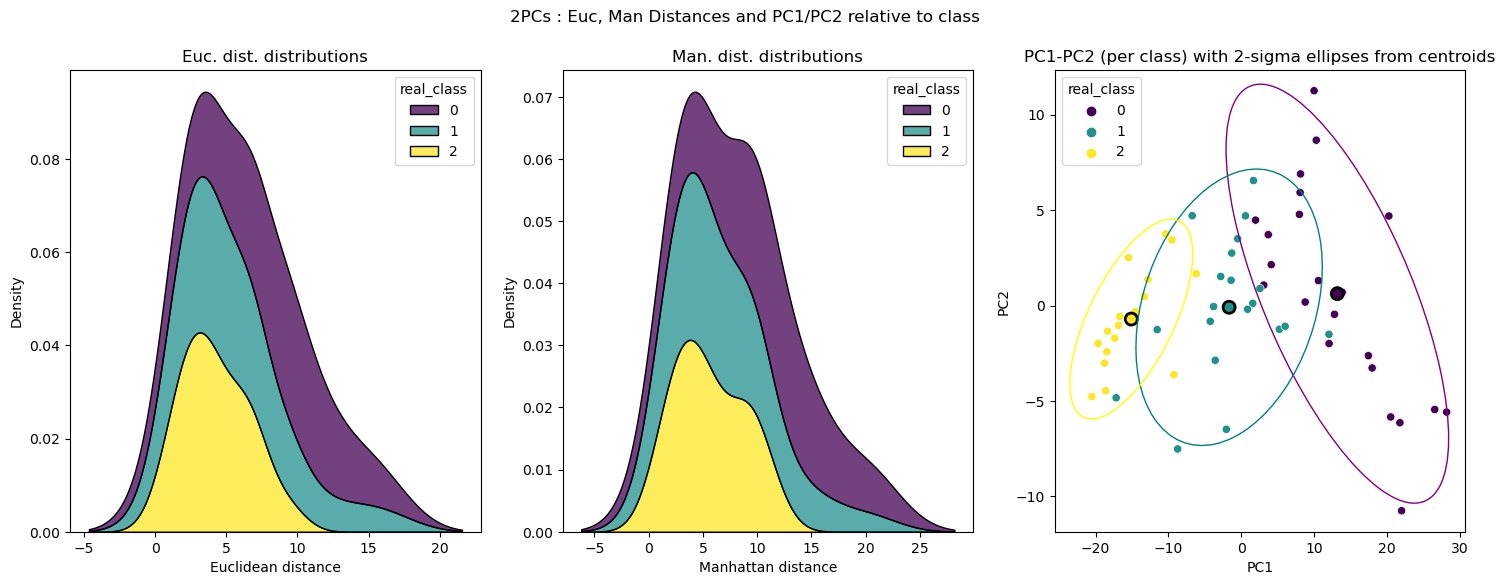

In [536]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.kdeplot(data=pca2c_dist, x="euc", hue="real_class", multiple="stack", palette="viridis", ax=axes[0])
axes[0].set_xlabel("Euclidean distance")
axes[0].set_title("Euc. dist. distributions")
sns.kdeplot(data=pca2c_dist, x="man", hue="real_class", multiple="stack", palette="viridis", ax=axes[1])
axes[1].set_xlabel("Manhattan distance")
axes[1].set_title("Man. dist. distributions")
sns.scatterplot(data=pca2c_dist, x="pc1", y="pc2", hue="real_class", palette="viridis", ax=axes[2])
sns.scatterplot(data=pca2c_centroids, x="pc1", y="pc2", hue="real_class", marker="o", linewidth=2, edgecolor="k", s=75, palette="viridis", legend=False, ax=axes[2])
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 0]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 0]["pc2"], axes[2], edgecolor="purple")
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 1]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 1]["pc2"], axes[2], edgecolor="teal")
confidence_ellipse(pca2c_dist[pca2c_dist["real_class"] == 2]["pc1"], pca2c_dist[pca2c_dist["real_class"] == 2]["pc2"], axes[2], edgecolor="yellow")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].set_title("PC1-PC2 (per class) with 2-sigma ellipses from centroids")
fig.suptitle("2PCs : Euc, Man Distances and PC1/PC2 relative to class")


For PCA with 3-dimensions

In [537]:
# Get Centroids
pca3c_df = pd.DataFrame(data3d, columns=["pc1","pc2", "pc3"])
pca3c_df["real_class"] = y.values
pca3c_centroids = pca3c_df.groupby("real_class").mean()
pca3c_centroids

,pc1,pc2,pc3
real_class,,,
0,13.189847,0.624828,1.165324
1,-1.671420,-0.087523,-2.162568
2,-15.102837,-0.705632,1.036132


In [538]:
# Euclidian/Manhattan distances to centroid class for 3PCs

# Difference to centroid
pca3c_dist = pca3c_df.groupby("real_class").transform(lambda x: (x - x.mean())).rename(columns = {"pc1" : "pc1-cent", "pc2" : "pc2-cent", "pc3" : "pc3-cent"})
# Manhattan dist
pca3c_dist["man"] = np.abs(pca3c_dist["pc1-cent"]) + np.abs(pca3c_dist["pc2-cent"]) + np.abs(pca3c_dist["pc3-cent"])
# Euclidean dist
pca3c_dist["euc"] = np.sqrt(np.power(pca3c_dist["pc1-cent"], 2) + np.power(pca3c_dist["pc2-cent"], 2)) + np.power(pca3c_dist["pc3-cent"], 2)
# Adding PC1, PC2 and classes back
pca3c_dist[["pc1", "pc2", "pc3"]] = pca3c_df[["pc1", "pc2", "pc3"]]
pca3c_dist["real_class"] = y.values
pca3c_dist.head()

,pc1-cent,pc2-cent,pc3-cent,man,euc,pc1,pc2,pc3,real_class
0,-3.191294,10.630896,3.461947,17.284138,23.084643,9.998553,11.255724,4.627271,0
1,0.667624,0.074133,-0.629525,1.371282,1.068029,13.857471,0.698961,0.535799,0
2,7.071894,4.070348,-3.927473,15.069715,23.584665,20.261741,4.695177,-2.762149,0
3,13.373477,-6.068369,0.412139,19.853985,14.855736,26.563323,-5.443541,1.577463,0
4,4.779972,-3.891427,6.187442,14.858841,44.448149,17.969818,-3.266599,7.352766,0


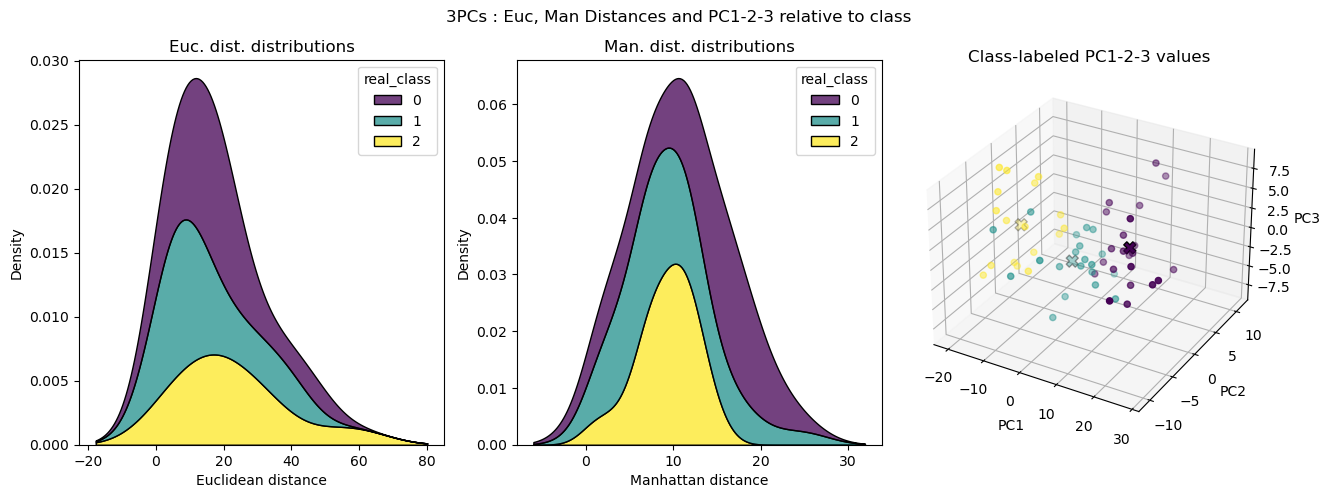

In [539]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))

sns.kdeplot(data=pca3c_dist, x="euc", hue="real_class", multiple="stack", palette="viridis", ax=axes[0])
axes[0].set_xlabel("Euclidean distance")
axes[0].set_title("Euc. dist. distributions")
sns.kdeplot(data=pca3c_dist, x="man", hue="real_class", multiple="stack", palette="viridis", ax=axes[1])
axes[1].set_xlabel("Manhattan distance")
axes[1].set_title("Man. dist. distributions")
axes[2].axis("off")
axes[2] = fig.add_subplot(1,3,3, projection="3d")
axes[2].scatter(pca3c_dist["pc1"], pca3c_dist["pc2"], pca3c_dist["pc3"], c=pca3c_dist["real_class"])
axes[2].scatter(pca3c_centroids["pc1"], pca3c_centroids["pc2"], pca3c_centroids["pc3"], c=pca3c_centroids.index, marker="X", linewidth=1, edgecolor="k", s=75)
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].set_zlabel("PC3")
axes[2].set_title("Class-labeled PC1-2-3 values")
fig.suptitle("3PCs : Euc, Man Distances and PC1-2-3 relative to class")
box = axes[2].get_position()
box.x0 = box.x0 - 0.03
box. x1 = box.x1 - 0.03
axes[2].set_position(box)


**There seems to be a better separation of the objects for each classes when we reduce the dimension to 3 components. The data points seem to be further away from each other and closer to their centroids with less overlap between classes**

Also note that the distances distribution seem less skewed, especially for the Manhattan distance when reducing from 4 to 3 components comparing to a 2PCs PCA

 ---

**Since we know that attribut1 has large distribution and is correlated with att3 and 4, we might benefit from using the Mahalanobis distance.** 

**Also, we see from the 2PC plot that if we use Euclidean distances later on for classification, we might get a lot of mislabeled predictions because some points of the training set might be actually closer (in Euclidean terms) to another class centroid even though they do not belong to that centroid's class. Mahalanobis distance takes into account the distribution and the correlation between variables**


#### b) Mahalanobis Distance
We want to compute the covariance matrix for all classes since we want to get the relationship between all the datapoints considering all features and not compared to class centroids. This would be a good approach to build a Mahalanobis distance-based classifier.

We could compute the covariance matrix per class and it would be a good approach to identify outliers per class and remove them.

(n_features > n_samples+1 so OK for covariance matrix calculation)

$D^2=(\boldsymbol{x}^i-\boldsymbol{x}^j)^\top\Sigma^{-1}(\boldsymbol{x}^i-\boldsymbol{x}^j)$, where $\Sigma$ is a $d\times d$ covariance matrix.

In [540]:
# All class distance
def calculate_mahalanobis(X):
    # Standardize data
    X_min_mu = X - np.mean(X, axis=0)
    # Covariance matrix 
    cov = np.cov(X.values.T)
    inv_cov = np.linalg.inv(cov)
    # Dot products of each terms
    lterm = np.dot(X_min_mu, inv_cov)
    squared_mah_dist = np.dot(lterm, X_min_mu.T).diagonal()
    mah_dist = np.sqrt(squared_mah_dist)
    return mah_dist
    

In [541]:
mah_dists = calculate_mahalanobis(pca3c_df.drop(columns="real_class"))
print(mah_dists[:5])

[3.06027253 1.07538927 2.04243044 2.4396043  2.50160709]


In [542]:
# Cross validation with sicpy builtin function for first object
distance.mahalanobis(pca3c_df.drop(columns="real_class").values[0], np.mean(pca3c_df.drop(columns="real_class"), axis=0), np.linalg.inv(np.cov(pca3c_df.drop(columns="real_class").values.T)))

3.0602725312024917

In [543]:
# Upper tail critical values of chi-square dist with df=3
thresh99 = np.sqrt(11.345)
print(thresh99)
(mah_dists > thresh99).any()

3.368233958619858


False

In [544]:
df_mah = pca3c_df.copy()
df_mah["mah"] = mah_dists
df_mah.head()

,pc1,pc2,pc3,real_class,mah
0,9.998553,11.255724,4.627271,0,3.060273
1,13.857471,0.698961,0.535799,0,1.075389
2,20.261741,4.695177,-2.762149,0,2.042430
3,26.563323,-5.443541,1.577463,0,2.439604
4,17.969818,-3.266599,7.352766,0,2.501607


We could then use the Mahalanobis distance to build a classifier based on the Mah distance when/if needed later on

---

### Classification models with KNN and NearestCentroid

#### a.1) Nearest centroid model with PCA (n_components verification)

In [545]:
# Nearest centroid classifier for 2PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data2d, y)
y_pred = ncc.predict(data2d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 2-dim : {ncc.score(data2d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 2dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 2-dim : 0.8305084745762712

Centroids values for 2dims : 

[[ 13.18984673   0.62482803]
 [ -1.67141988  -0.08752333]
 [-15.10283708  -0.70563236]]


In [546]:
# Nearest centroid classifier for 3PC
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d, y)
y_pred = ncc.predict(data3d)

# Using the built-in accuracy in sklearn
print(f"Mean accuracy with PCA reduction to 3-dim : {ncc.score(data3d, y)}\n")
# Or numpy np.mean(y == y_pred)

print(f"Centroids values for 3dims : \n\n{ncc.centroids_}")

Mean accuracy with PCA reduction to 3-dim : 0.847457627118644

Centroids values for 3dims : 

[[ 13.18984673   0.62482803   1.16532378]
 [ -1.67141988  -0.08752333  -2.16256844]
 [-15.10283708  -0.70563236   1.03613209]]


<Figure size 640x480 with 0 Axes>

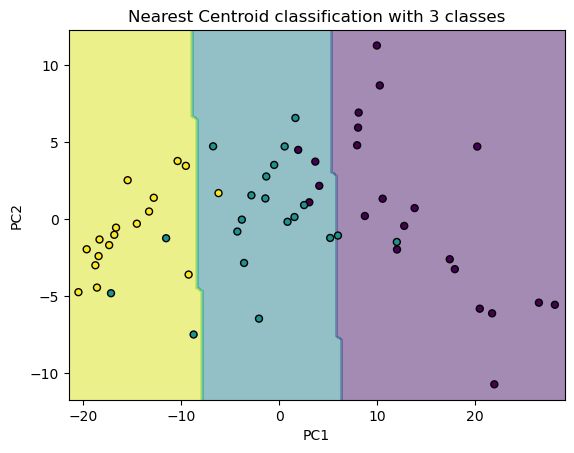

In [547]:
# for visualization of the 3PC (only first 2 PC of PCA-3dims)
clf = NearestCentroid(metric="euclidean")
ncc = clf.fit(data3d[:, :2], y)
y_pred = ncc.predict(data3d[:, :2])

plt.figure()
DecisionBoundaryDisplay.from_estimator(ncc, data3d[:, :2], response_method="predict", alpha=0.5)
plt.scatter(data3d[:, 0], data3d[:,1], marker=".", s=100, c=y, edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Nearest Centroid classification with 3 classes")
plt.show()

Here, we see that accuracy is slightly better with n_components = 3 with PCA

#### a.2) Splitting the data in training (70%) and test (30%) data sets
Higher proportion of test data since we don't have a lot of objects in the dataset

In [548]:
# Make sure we have the indices for the splitting
print("X values")
print(type(X))
print(X.head(3))
print("\n y values")
print(type(y))
print(y.head(3))

X values
<class 'pandas.core.frame.DataFrame'>
     attribut1  attribut2  attribut3  attribut4
id1       38.0       33.0       10.0       19.0
id2       38.2       23.4       17.0       16.6
id3       33.0       24.0       19.0       23.0

 y values
<class 'pandas.core.series.Series'>
id1    0
id2    0
id3    0
Name: classe, dtype: int64


In [549]:
# Setting seed to be consistent when rerunning the notebook
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [550]:
print(f"{X_train.head(3)}\n\n{y_train.head(3)}")

      attribut1  attribut2  attribut3  attribut4
id15       28.7       20.5       29.1       14.6
id33       40.7       18.7       16.4       18.5
id50       56.1       24.0        0.3       15.0

id15    0
id33    1
id50    2
Name: classe, dtype: int64


In [551]:
# Apply PCA with n_components = 3 on training and test sets
pca = PCA(n_components=3).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca \n{X_train_pca[:5, :]}")
print(f"y_train_pca \n {X_test_pca[:5, :]}")

X_train_pca 
[[ 27.94689554  -4.28437969   2.8224716 ]
 [ 11.79994344  -1.01979463  -4.40177515]
 [-10.83066141   3.52561508  -2.46085103]
 [-17.42553288  -5.13722366   1.7150813 ]
 [ -4.0308195   -0.21431653  -7.48040337]]
y_train_pca 
 [[ -1.79426502   2.93699738   0.30193669]
 [  5.75307689  -0.78480647  -3.80768457]
 [-16.92022154  -1.10000175  -5.20442221]
 [  0.10331407   4.80811479  -3.89930388]
 [  8.36443329   0.74064676   0.54558278]]


In [552]:
# Train the NearestCentroid model with Euclidean distance

# Setting parameters for the classifier
clf = NearestCentroid(metric="euclidean")
# Training the classifier
ncc = clf.fit(X_train_pca, y_train)
y_pred = ncc.predict(X_test_pca)
print(f"Training set mean accuracy : {ncc.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.8049
Test set mean accuracy : 0.9444


In [553]:
# Per class metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18



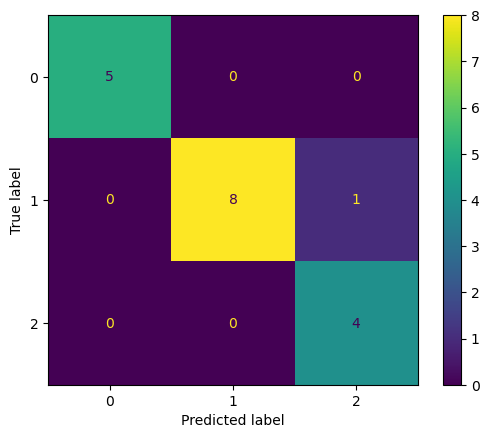

In [554]:
# As confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#### a.3) Nearest Neighbords (with k=5) classification model

KNN with Euclidean distance

In [555]:
# KNN classifier with 3PCs using Euc

# Setting the k hyperparams + distance
neigh = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Train the model
neigh.fit(X_train_pca, y_train)

# Predictions
y_pred = neigh.predict(X_test_pca)

print(f"Training set mean accuracy : {neigh.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.8049
Test set mean accuracy : 0.9444


In [556]:
# Per class metrics KNN-Euc
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18



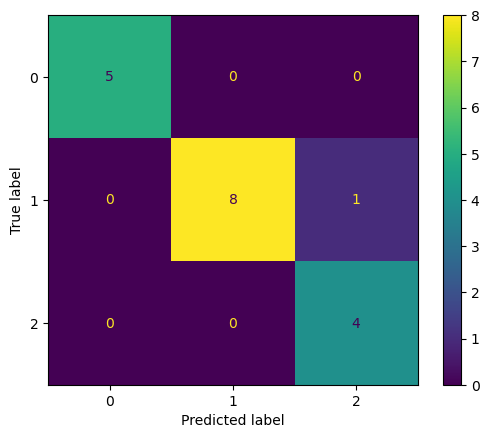

In [557]:
# Confusion matrix KNN-Euc
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [558]:
# KNN classifier with 3PCs

# Setting the k hyperparams + Mahalanobis distance
neigh_mah = KNeighborsClassifier(n_neighbors=5, metric="mahalanobis", metric_params={"V" : np.cov(X_train_pca.T)})

# Train the model
neigh_mah.fit(X_train_pca, y_train)

# Get predictions
y_pred = neigh_mah.predict(X_test_pca)

# Per class metrics
print(f"Training set mean accuracy : {neigh_mah.score(X_train_pca, y_train):.4f}")
print(f"Test set mean accuracy : {metrics.accuracy_score(y_test, y_pred):.4f}")

Training set mean accuracy : 0.9268
Test set mean accuracy : 0.8889


In [559]:
# Per class metrics KNN-Mah
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.78      1.00      0.88         7
           2       1.00      0.80      0.89         5

    accuracy                           0.89        18
   macro avg       0.93      0.88      0.89        18
weighted avg       0.91      0.89      0.89        18



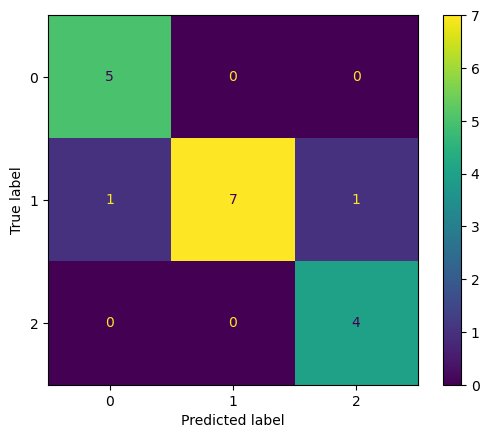

In [560]:
# As confusion matrix KNN-mah
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

**If we just look at accuracy, it seems that the best model would be the KNN with Euclidean distance. However, there is such a high difference in the accuracy between the training and test sets in that model that we should run some cross-validation tests. It is likely that the model might show some bias.**

#### b) Gaussian Mixture Model

Even though this is a supervised learning problem, let's see how many components are suggested to use in our GMM using Bayesian Information Criterion with full covariance and no dimensionality reduction

None


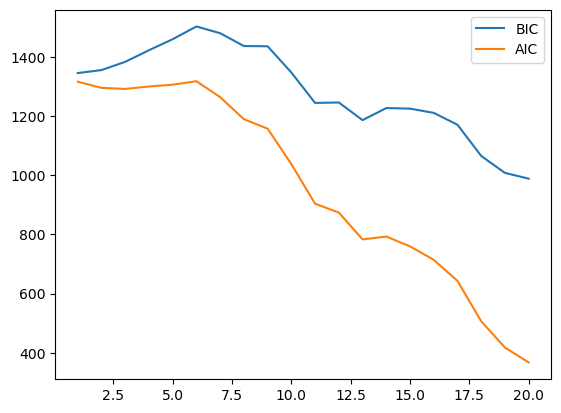

In [561]:
# BIC hyperparameter optimization 
def optimize_gmm_compo(max_compo, X):
    n_compo_range = np.arange(1,max_compo+1)
    covar_type = "full"
    gmms = [GaussianMixture(i, covariance_type="full", random_state=0).fit(X) for i in n_compo_range]
    bics = [gmm.bic(X)for gmm in gmms]
    aics = [gmm.aic(X) for gmm in gmms]
    plt.plot(n_compo_range, bics, label="BIC")
    plt.plot(n_compo_range, aics, label="AIC")    
    plt.legend()
        
print(optimize_gmm_compo(20, X))

Looking at the profile for 2PC/3PC reduced dims

None


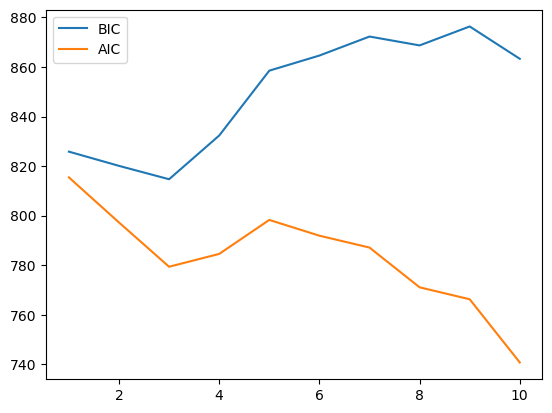

In [562]:
#2PCs BIC/AICs
print(optimize_gmm_compo(10, pca2c_df.drop(columns='real_class')))

None


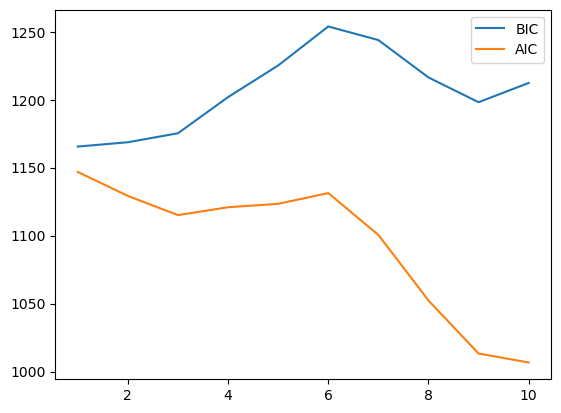

In [563]:
#3PCs BIC/AICs
print(optimize_gmm_compo(10, pca3c_df.drop(columns='real_class')))

Hyperparameter of covariance choice:
- diag = Aligns with the axes 
- spherical = Almost like euclidean distance meaning that the shape of the cluster won't represent the distributions
- full = covariance per cluster
- tied = covariance shape is the same of all clusters

I say full will give us the best model since we know looking back at the per cluster distributions of PCA-reduced data that each cluster still had different covariance per PC. Let's look at all of them and evaluate the best scoring model

In [564]:
# Gaussian Mixture Model classification for different
def gmm_models(X_train, y_train, X_test, y_test, n_compo):
    cov_types = ["diag", "spherical", "tied", "full"]
    # Set the classifiers
    gms = {}
    for cov in cov_types:
        gms[cov] = GaussianMixture(n_components=n_compo, covariance_type=cov, random_state=0).fit(X_train, y_train)
    # Make predictions and evaluate accuracy
    for cov, gm in gms.items():
        y_pred = gm.predict(X_test)
        print(f"Accuracy for GMM with cov_type={cov} : {metrics.accuracy_score(y_test, y_pred):.4f}")


In [565]:
gmm_models(X_train, y_train, X_test, y_test, 3)

Accuracy for GMM with cov_type=diag : 0.0556
Accuracy for GMM with cov_type=spherical : 0.1111
Accuracy for GMM with cov_type=tied : 0.1111
Accuracy for GMM with cov_type=full : 0.3333


In [566]:
gmm_models(X_train_pca, y_train, X_test_pca, y_test, 3)

Accuracy for GMM with cov_type=diag : 0.0000
Accuracy for GMM with cov_type=spherical : 0.1667
Accuracy for GMM with cov_type=tied : 0.1111
Accuracy for GMM with cov_type=full : 0.2778


GMM is the worst performing classifier so far.

---

### 4. Application

Let's classify the new data points with the best performing model so far, KNN with EUclidean distance

Array to classify : [52.1, 23.0, 6.1, 16.5]

In [567]:
# Unknown data
unknown = pd.DataFrame(np.array([52.1, 23.0, 6.1, 16.5]).reshape(1, -1), columns=features)


Before performing the prediction, let's re-train our PCA and KNN model using the whole dataset

In [568]:
# Dimens-redux with PCA
pca = PCA(n_components=3).fit(X)
X_3pc = pca.transform(X)
unknown_3pc = pca.transform(unknown)

# KNN classifier with Euclidean distance

# Setting the k hyperparams + distance
neigh = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Train the model
neigh.fit(X_3pc, y)

# Predictions
y_pred = neigh.predict(X_3pc)
unknown_pred = neigh.predict(unknown_3pc)

print(f"Whole dataset mean accuracy : {metrics.accuracy_score(y, y_pred):.4f}")
print(f"Predicted class for unknown point : {unknown_pred[0]}")


Whole dataset mean accuracy : 0.8475
Predicted class for unknown point : 1


In [569]:
# DataFrame for ellipse
df_3pc = pd.DataFrame(X_3pc, columns=["pc1", "pc2", "pc3"])
df_3pc["real_class"] = y.values
df_3pc.head()

,pc1,pc2,pc3,real_class
0,9.998553,11.255724,4.627271,0
1,13.857471,0.698961,0.535799,0
2,20.261741,4.695177,-2.762149,0
3,26.563323,-5.443541,1.577463,0
4,17.969818,-3.266599,7.352766,0


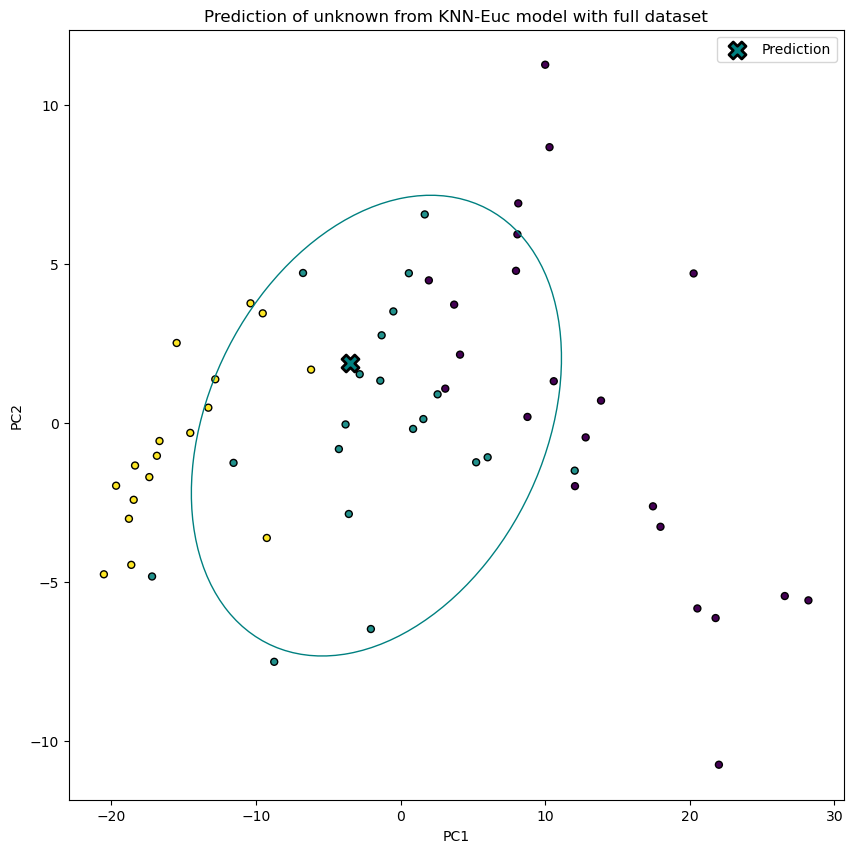

In [570]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_3pc[:, 0], X_3pc[:,1], marker=".", s=100, c=y, edgecolors="k")
ax.scatter(unknown_3pc[:, 0], unknown_3pc[:, 1], marker="X", edgecolors="k", linewidths=2, c="teal", s=150, label="Prediction")
confidence_ellipse(df_3pc[df_3pc["real_class"] == 1]["pc1"], df_3pc[df_3pc["real_class"] == 1]["pc2"], ax, edgecolor="teal")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Prediction of unknown from KNN-Euc model with full dataset")
ax.legend()